In [408]:
import numpy as np
from numpy import linalg as lin
import random as rn
from pyvis.network import Network
import pandas as pd
import matplotlib.pyplot as plt

In [409]:
import triad_utils as tu

In [410]:
# UNIX
! rm net_names.txt
#v1) ! ls database >> net_names.txt
! ls matrices >> net_names.txt

In [411]:
file = open('net_names.txt')
net_names = [name.rstrip() for name in file]

In [412]:
len(net_names)

71

In [413]:
census = []
for net_num in range(len(net_names)):
    matrix = np.loadtxt('matrices/'+net_names[net_num], dtype=int)
    n = len(matrix)
    for i in range(n):
        matrix[i,i] = 0 # removal of self-loops
    t = tu.triad_census(matrix)
    census.append(list(t))
    
df1 = pd.DataFrame(census)
df1.columns = ['t'+str(i) for i in range(1,14)]
df1.to_csv('triads_count.csv')

In [414]:
df1.head()

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13
0,33,31,87,10,18,0,8,1,0,1,2,0,1
1,47,34,53,18,20,3,51,4,1,6,12,5,0
2,123,85,180,22,26,2,38,3,3,0,7,0,0
3,9,12,25,13,6,2,1,0,2,2,1,3,1
4,36,44,68,12,8,0,2,1,0,0,0,0,0


In [415]:
norm_df1 = df1.div(df1.sum(axis=1), axis=0) 

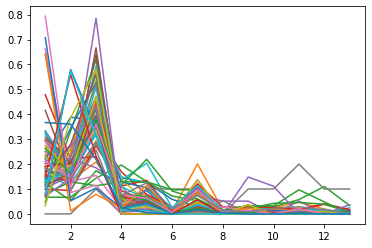

In [416]:
for i in range(len(norm_df1)):
    pr = norm_df1.loc[i]
    t = np.arange(1,14)
    plt.plot(t,pr)

In [417]:
data = [ list(norm_df1['t'+str(i+1)]) for i in range(13) ]

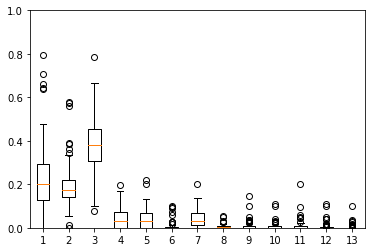

In [418]:
plt.boxplot(data,notch=False)
plt.ylim(0,1);

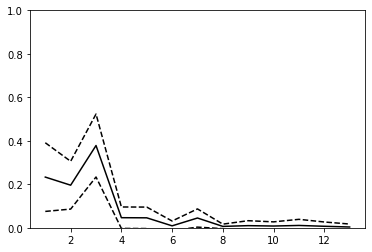

In [419]:
m = norm_df1.mean()
s = norm_df1.std()

plt.plot(t,m,'k')
plt.plot(t,m+s,'k--')
plt.plot(t,m-s,'k--')
plt.ylim(0,1);

In [420]:
df1.mean(axis=1,numeric_only=True)

0     14.769231
1     19.538462
2     37.615385
3      5.923077
4     13.153846
        ...    
66    10.923077
67    74.538462
68     2.384615
69     5.615385
70    34.384615
Length: 71, dtype: float64

# Random

In [421]:
ensemble_size = 5000

significance = []

for net_num in range(len(net_names)):
    matrix = np.loadtxt('matrices/'+net_names[net_num], dtype=int)
    n = len(matrix)
    n_edges = len(tu.edge_list(matrix))
    
    for i in range(n):
        matrix[i,i] = 0 # removal of self-loops
    t = tu.triad_significance_profile(matrix, ensemble_size, 100*n_edges)
    significance.append(list(t))
    
    print(net_num)
    
df2 = pd.DataFrame(significance)
df2.columns = ['t'+str(i) for i in range(1,14)]
df2.to_csv('significance_profiles.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70


In [422]:
# ----- START FROM HERE -----
# started at 4pm Dec 23

In [423]:
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2022-12-24 18:32:50


In [424]:
#df_result = pd.DataFrame(result)
df2

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13
0,-3.327985,-2.615800,-2.505684,0.858523,1.839174,-0.449239,1.661475,-0.896119,-0.357338,1.821052,2.405355,-0.154981,49.989999
1,1.457182,0.300165,1.146321,0.333535,-0.760892,-0.213589,0.869471,-0.316062,-1.803637,-1.542597,1.020610,0.322144,-0.514457
2,-4.580463,-4.720038,-3.684189,0.913074,1.301756,2.225045,5.338978,-0.569402,3.238808,-0.605556,6.307215,-0.215445,0.000000
3,-1.365422,-2.590747,-1.657359,0.559395,-1.040308,0.397745,-1.214664,-1.170973,2.467043,1.460382,-0.362689,3.822525,5.980434
4,1.391072,0.806411,0.485600,0.791022,0.708146,-0.499559,-1.991850,-0.650218,-0.716169,-0.542137,-0.814681,-0.257600,-0.024502
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,-3.396108,-3.940318,-2.741594,1.118707,0.819625,1.531019,2.785950,-0.768560,3.185741,-0.446702,3.692592,-0.165090,0.000000
67,-1.016132,-0.252908,-0.584690,-0.140083,0.473819,0.648470,-0.798298,-1.195668,-1.010934,0.561370,0.453688,1.079822,1.960247
68,0.726396,0.829090,1.154675,-0.751425,-0.493742,-0.076380,-0.368575,-0.594869,-0.066479,0.000000,-0.141393,0.000000,0.000000
69,0.707005,0.768895,0.297739,-0.322655,0.457297,-0.123446,-1.171836,-0.423910,-0.151028,-0.129126,-0.208048,-0.054855,0.000000


In [425]:
df2.to_csv('New_run5000.csv')  

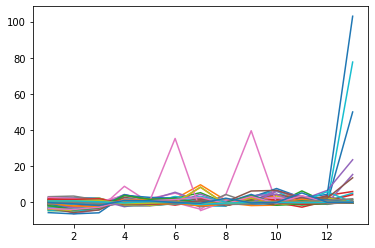

In [426]:
for i in range(len(df2)):
    pr = np.array(df2.loc[i])
    t = np.arange(1,14)
    plt.plot(t,pr)
#    plt.ylim(-1,1)

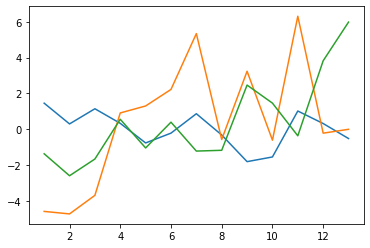

In [427]:
t = np.arange(1,14)
z1 = np.array(df2.loc[1])
z2 = np.array(df2.loc[2])
z3 = np.array(df2.loc[3])
plt.plot(t,z1)
plt.plot(t,z2)
plt.plot(t,z3)

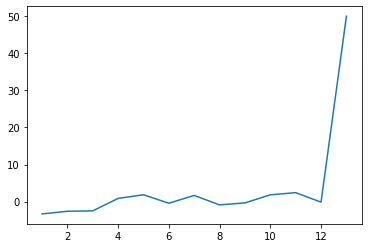

In [428]:
t = np.arange(1,14)
z0 = np.array(df2.loc[0])
plt.plot(t,z0)

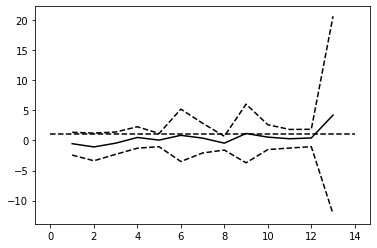

In [429]:
m = df2.mean()
s = df2.std()

plt.plot(t,m,'k')
plt.plot(t,m+s,'k--')
plt.plot(t,m-s,'k--')

plt.plot([0,14],[1,1],'--k')

# PCA of the direct census

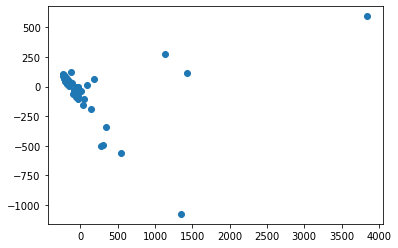

In [430]:
data0 = np.array(df1)
X_centered = df1 - df1.mean(axis = 0)
U, s , Vt = np.linalg.svd(X_centered)

W2 = Vt.T[:,:2]
X2D = X_centered.dot(W2)
PCA1 = X2D[0]
PCA2 = X2D[1]

plt.scatter(PCA1,PCA2);

# PCA of the normalized census

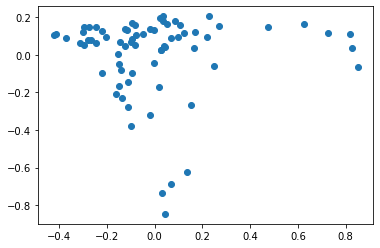

In [431]:
df1_norm = df1.div(
    np.linalg.norm(df1,axis=1),
    axis=0)

data1 = np.array(df1_norm)
X_centered = df1_norm - df1_norm.mean(axis = 0)
U, s , Vt = np.linalg.svd(X_centered)

W2 = Vt.T[:,:2]
X2D = X_centered.dot(W2)
PCA1 = X2D[0]
PCA2 = X2D[1]

plt.scatter(PCA1,PCA2);

# PCA of the Significance Profiles

In [432]:
# Normalization: Z -> SP
df2_norm = df2.div(
    np.linalg.norm(df2,axis=1),
    axis=0)

In [433]:
df2_norm

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13
0,-0.066029,-0.051899,-0.049714,0.017034,0.036490,-0.008913,0.032965,-0.017780,-0.007090,0.036131,0.047724,-0.003075,0.991831
1,0.417841,0.086071,0.328703,0.095640,-0.218183,-0.061246,0.249317,-0.090629,-0.517185,-0.442333,0.292656,0.092373,-0.147518
2,-0.381938,-0.393576,-0.307203,0.076136,0.108546,0.185533,0.445186,-0.047479,0.270065,-0.050494,0.525922,-0.017965,0.000000
3,-0.158246,-0.300255,-0.192080,0.064831,-0.120566,0.046097,-0.140774,-0.135710,0.285918,0.169251,-0.042034,0.443012,0.693103
4,0.437158,0.253422,0.152604,0.248586,0.222542,-0.156991,-0.625958,-0.204337,-0.225063,-0.170372,-0.256021,-0.080953,-0.007700
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,-0.402459,-0.466951,-0.324895,0.132573,0.097130,0.181435,0.330152,-0.091079,0.377529,-0.052937,0.437594,-0.019564,0.000000
67,-0.310330,-0.077239,-0.178566,-0.042782,0.144706,0.198045,-0.243803,-0.365161,-0.308742,0.171444,0.138558,0.329781,0.598666
68,0.368928,0.421086,0.586447,-0.381641,-0.250766,-0.038792,-0.187195,-0.302128,-0.033764,0.000000,-0.071812,0.000000,0.000000
69,0.398552,0.433440,0.167841,-0.181887,0.257787,-0.069589,-0.660586,-0.238966,-0.085137,-0.072791,-0.117280,-0.030923,0.000000


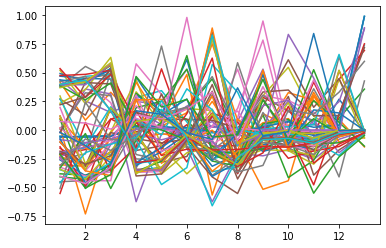

In [434]:
for i in range(len(df2_norm)):
    sp = np.array(df2_norm.loc[i])
    t = np.arange(1,14)
    plt.plot(t,sp)
#    plt.ylim(-1,1)

In [435]:
# Cleanup


data_new1 = df2_norm.copy()                                    # Create duplicate of data
data_new1.replace([np.inf, - np.inf], np.nan, inplace = True)  # Exchange inf by NaN
data_new1

data_new2 = data_new1.dropna()                                 # Delete rows with NaN
data_new2

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13
0,-0.066029,-0.051899,-0.049714,0.017034,0.036490,-0.008913,0.032965,-0.017780,-0.007090,0.036131,0.047724,-0.003075,0.991831
1,0.417841,0.086071,0.328703,0.095640,-0.218183,-0.061246,0.249317,-0.090629,-0.517185,-0.442333,0.292656,0.092373,-0.147518
2,-0.381938,-0.393576,-0.307203,0.076136,0.108546,0.185533,0.445186,-0.047479,0.270065,-0.050494,0.525922,-0.017965,0.000000
3,-0.158246,-0.300255,-0.192080,0.064831,-0.120566,0.046097,-0.140774,-0.135710,0.285918,0.169251,-0.042034,0.443012,0.693103
4,0.437158,0.253422,0.152604,0.248586,0.222542,-0.156991,-0.625958,-0.204337,-0.225063,-0.170372,-0.256021,-0.080953,-0.007700
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,-0.402459,-0.466951,-0.324895,0.132573,0.097130,0.181435,0.330152,-0.091079,0.377529,-0.052937,0.437594,-0.019564,0.000000
67,-0.310330,-0.077239,-0.178566,-0.042782,0.144706,0.198045,-0.243803,-0.365161,-0.308742,0.171444,0.138558,0.329781,0.598666
68,0.368928,0.421086,0.586447,-0.381641,-0.250766,-0.038792,-0.187195,-0.302128,-0.033764,0.000000,-0.071812,0.000000,0.000000
69,0.398552,0.433440,0.167841,-0.181887,0.257787,-0.069589,-0.660586,-0.238966,-0.085137,-0.072791,-0.117280,-0.030923,0.000000


In [436]:
len(data_new2)

71

In [437]:
# K-Means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [438]:
X = data_new2

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 20)]

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

In [439]:
silhouette_scores

[0.32558764019492487,
 0.28177751838631643,
 0.3064596479198073,
 0.30394907908394747,
 0.2957588583947372,
 0.26308299505523636,
 0.2644210183614201,
 0.28612426735873076,
 0.24618868646885175,
 0.2923711419069607,
 0.27270047903499783,
 0.27282115618843655,
 0.2724136049005076,
 0.27031181869147614,
 0.30023407652003414,
 0.2980052907406582,
 0.280675774740696,
 0.28062516249037256]

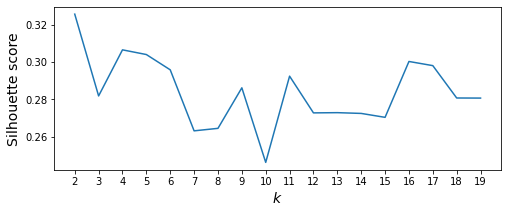

In [440]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 20), silhouette_scores)
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.xticks(np.arange(2, 20, step=1))
plt.show()

In [453]:
k = 4
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(data_new2)

In [454]:
M1 = np.array([
[-0.5, -0.5060241, -0.5,0.0060241, -0.0060241,-0.0060241,0.5,0.0060241,  0.0060241, -0.0060241,
0., -0.0060241,0.],
[-0.5, -0.5, -0.5060241,0.,0.05421687,-0.01204819,0.5,-0.0060241,-0.0060241,-0.0060241,0.,0.,-0.0060241]
])



M2 = np.array([[-0.21038251, -0.33060109,  0.06830601, -0.25956284, -0.50546448,
        0.00273224,  0.13934426,  0.00273224,  0.41256831,  0.59289617,
       -0.00819672,  0.1010929 , -0.00273224],
               [-0.33060109, -0.34153005, -0.11202186, -0.34699454, -0.40710383,
       -0.23770492,  0.25409836, -0.09016393,  0.33060109,  0.43989071,
        0.03005464,  0.19398907,  0.12295082]
    
])

M3= np.array([
    [-0.0248 , -0.0248 , -0.0106 , -0.436  , -0.0745 , -0.677  ,
        0.00355,  0.0319 ,  0.457  ,  0.0603 ,  0.0532 ,  0.188  ,
        0.238  ],
    [-0.0957, -0.0816, -0.0461, -0.564 , -0.202 , -0.401 ,  0.0319,
        0.0674,  0.45  ,  0.195 ,  0.0745,  0.323 ,  0.372 ]
    
])

M4 = np.array(

[
[ 0.48   ,  0.5    ,  0.493  ,  0.147  ,  0.153  ,  0.0667 ,
       -0.353  , -0.24   , -0.12   , -0.127  , -0.147  , -0.0667 ,
        0.00667],
    [ 0.433,  0.413,  0.347,  0.273,  0.227,  0.193, -0.413, -0.18 ,
       -0.267, -0.167, -0.227, -0.16 , -0.08 ]
]
)



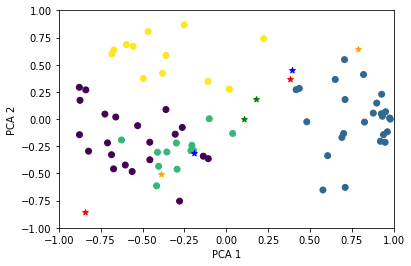

In [455]:
# PCA All data

X_centered = df2_norm - df2_norm.mean(axis = 0)
U, s , Vt = np.linalg.svd(X_centered)

W2 = Vt.T[:,:2]
X2D = X_centered.dot(W2)
PCA1 = X2D[0]
PCA2 = X2D[1]

plt.scatter(PCA1,PCA2, c=y_pred, label=y_pred)

# Milo family 1 (2 points, complete)

M1_centered = M1 -np.array(df2_norm.mean(axis = 0))
M1_2D = M1_centered.dot(W2)
milo_1_PCA1 = M1_2D[0]
milo_1_PCA2 = M1_2D[1]
plt.scatter(milo_1_PCA1,milo_1_PCA2, c='red',marker = '*')

# Milo family 2 (2 point)

M2_centered = M2 -np.array(df2_norm.mean(axis = 0))
M2_2D = M2_centered.dot(W2)
milo_2_PCA1 = M2_2D[0]
milo_2_PCA2 = M2_2D[1]
plt.scatter(milo_2_PCA1,milo_2_PCA2, c='blue',marker = '*')

# Milo family 3 (2 point)

M3_centered = M3 -np.array(df2_norm.mean(axis = 0))
M3_2D = M3_centered.dot(W2)
milo_3_PCA1 = M3_2D[0]
milo_3_PCA2 = M3_2D[1]
plt.scatter(milo_3_PCA1,milo_3_PCA2, c='green',marker = '*')

# Milo family 4 (2 point)

M4_centered = M4 -np.array(df2_norm.mean(axis = 0))
M4_2D = M4_centered.dot(W2)
milo_4_PCA1 = M4_2D[0]
milo_4_PCA2 = M4_2D[1]
plt.scatter(milo_4_PCA1,milo_4_PCA2, c='orange',marker = '*')


plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('PCA 1');
plt.ylabel('PCA 2');

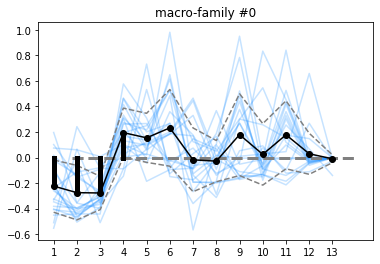

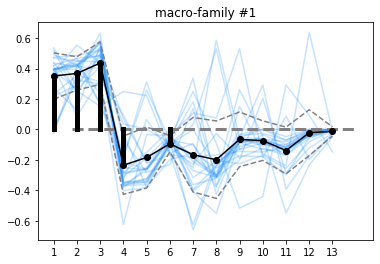

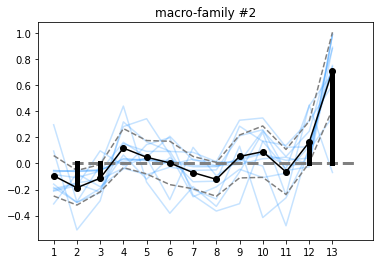

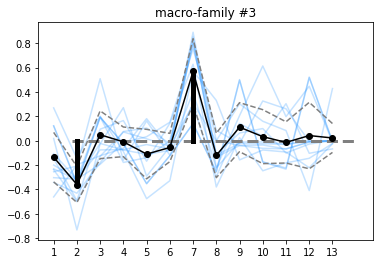

In [456]:
t = np.arange(0,13)
for y in np.unique(y_pred):
    selected_data = []
    for i in range(len(df2_norm)):
        if y_pred[i] == y:
            sp = np.array(df2_norm.iloc[i])
            selected_data.append(sp)
            plt.plot(t,sp,alpha=.25, c = 'dodgerblue')
    m = np.mean(np.array(selected_data),axis=0)
    s = np.std(np.array(selected_data),axis=0)
        
    plt.plot([0.8,13.1],[0,0],'--',c='gray',linewidth=3)
    
    plt.plot(t,m,'k')
    plt.plot(t,m,'ok')
    plt.plot(t,m+s,'--',c='gray')
    plt.plot(t,m-s,'--',c='gray')

    for k in range(13):
        if 0 <= m[k] - s[k] or 0>= m[k] + s[k]:
            plt.plot([k,k],[0,m[k]], c = 'k' ,linewidth=5)
    
    plt.xticks(np.arange(13), [str(i) for i in range(1,14)])
    
    plt.title('macro-family #'+str(y))
    plt.show()